### This notebook introduces a technique to generate sine waves and generates a data file used by the GNURadio flowgraph TDS_Introduction_sine_waves.grc

In [11]:
%matplotlib notebook
#Use "%matplotlib notebook" to interact with the plots
#Use "%matplotlib inline" to only create images  
#Ref: https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
GNURadioDatafileName = '../data/TDS_Introduction_sine_waves_complex64.bin'
GNURadioFlowgraphName='TDS_Introduction_sine_waves.grc'

To understand time delay spectrometry (TDS) we need to understand the waveform which is used by TDS called a chirp. A chirp is a sinusoid that is constantly varying in frequency. The chirp is generated by integrating a varying angle step which is derived from an instantaneous frequency profile. This waveform generation procedure can be illustrated with a waveform simpler than a chirp--a complex sinusoid which can be thought of as a chirp that doesn't vary in frequency. We create a waveform which is three cycles of a complex sine wave using the same formulation that we will use for a chirp in a later notebook. The equation for a complex sinusoid is: $e^{(j2\pi ft)}$. We will derive the time domain values by summing angle increments. An overview of this technique is given [here](https://www.youtube.com/watch?v=RQplkt0bw_c). 

Instantaneous frequency is a topic central to this waveform generation. A good primer on instantaneous frequency is given in the [video](https://youtu.be/fqkLgJ0Czoc?t=90) for the time [1:30-4:44].

<IPython.core.display.Javascript object>


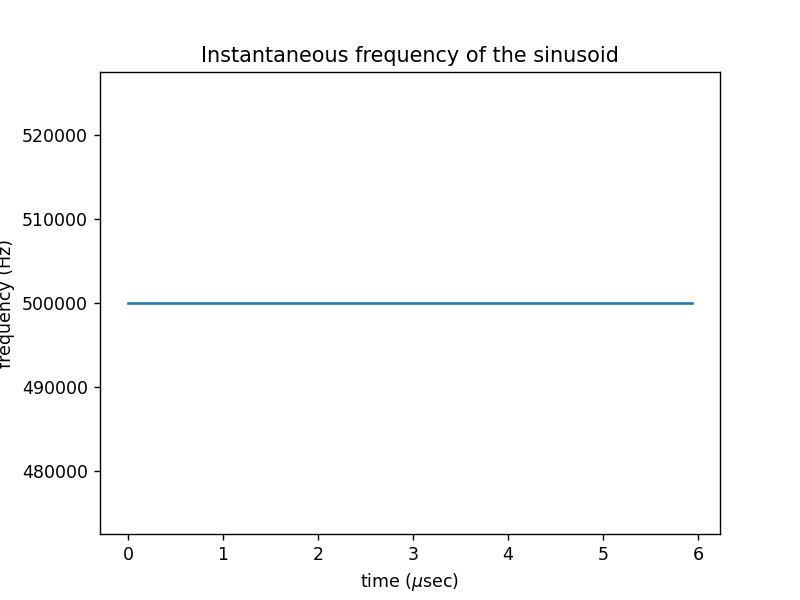

In [13]:
#Assume we want to create a waveform that is 3 cycles of a 500 KHz sine wave. 
total_cycles=3
f_sine_Hz=5e5

#The time for a single cycle is
t_cycle_sec=1/f_sine_Hz

#The time for the waveform is
Tc_sec=t_cycle_sec*total_cycles

#We want to digitize the waveform so its features are easily observaable. Therefore we use 32 samples per cycle
samples_per_cycle=32
fs=f_sine_Hz*samples_per_cycle
ts=1/fs

#This means we need to have the below number of samples to display the waveform
total_samples= math.ceil(fs*Tc_sec)
n = np.arange(0,total_samples, step=1, dtype=np.float64)

#The time domain signal looks like
t_sec=n*ts
t_usec = t_sec *1e6  #This makes plotting easier

#The instantaneous frequency is constant for all points in the waveform since it is a single sinusoid
sine_instantaneous_freq_Hz=t_sec*0+f_sine_Hz
sine_instantaneous_angular_freq_radPerSec=2*np.pi*sine_instantaneous_freq_Hz

fig, ax = plt.subplots(1, 1)
ax.plot(t_usec,sine_instantaneous_freq_Hz);
ax.set_title('Instantaneous frequency of the sinusoid')
ax.set_ylabel('frequency (Hz)')
ax.set_xlabel('time ($\mu$sec)');

<IPython.core.display.Javascript object>


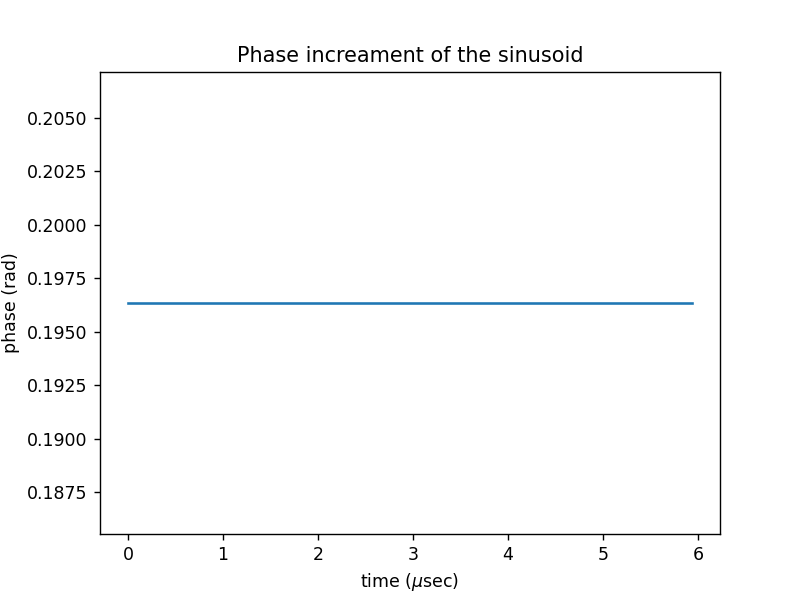

In [14]:
#Since frequency is a change in phase we can multiply it by the time step to find the amount
#of phase change every step, which is fixed.
sine_phase_step_rad=sine_instantaneous_angular_freq_radPerSec*ts

fig, ax = plt.subplots(1, 1)
ax.plot(t_usec,sine_phase_step_rad);
ax.set_title('Phase increament of the sinusoid')
ax.set_ylabel('phase (rad)')
ax.set_xlabel('time ($\mu$sec)');

<IPython.core.display.Javascript object>


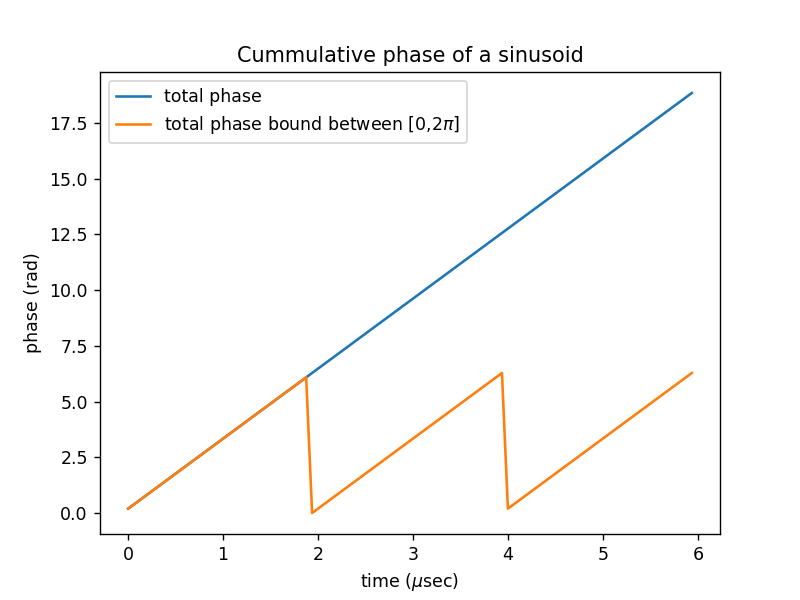

In [15]:
#The actual phase at each point in time is the summation of all the previous phase steps
sine_phase_rad=np.cumsum(sine_phase_step_rad)
fig, ax = plt.subplots(1,1)

ax.plot(t_usec,sine_phase_rad,label='total phase');
ax.plot(t_usec,np.fmod(sine_phase_rad,2*np.pi),label='total phase bound between [0,2$\pi$]');
ax.set_title('Cummulative phase of a sinusoid')
ax.set_ylabel('phase (rad)')
ax.set_xlabel('time ($\mu$sec)')
ax.legend()

<IPython.core.display.Javascript object>


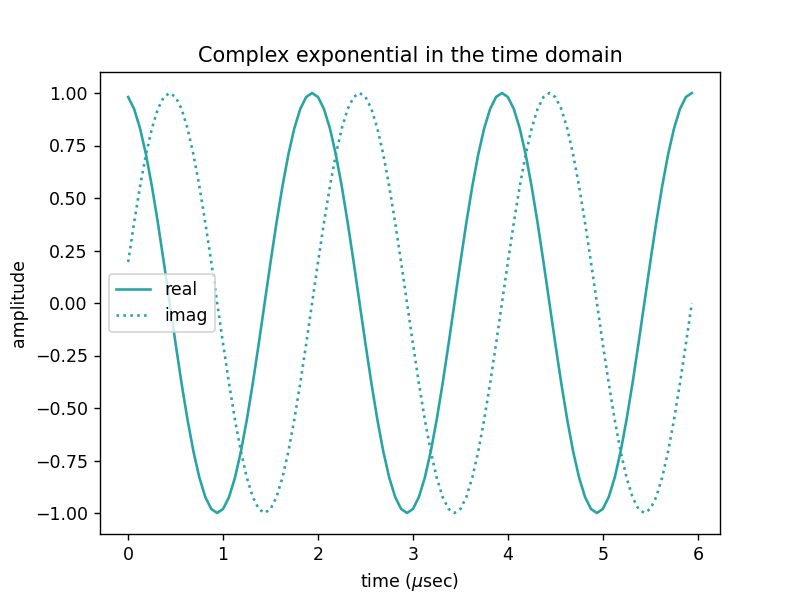

In [16]:
#We now take the complex exponential of the cumulative phase values to get the time domain complex exponential
#with the correct number of cycles
sine = np.exp(1j*sine_phase_rad)

fig, ax = plt.subplots(1, 1)
ax.plot(t_usec,np.real(sine),color='#27A4A3',label='real');
ax.plot(t_usec,np.imag(sine),color='#27A4A3',label='imag', linestyle=':');
ax.set_title('Complex exponential in the time domain')
ax.set_xlabel('time ($\mu$sec)')
ax.set_ylabel('amplitude')
ax.legend();

<IPython.core.display.Javascript object>


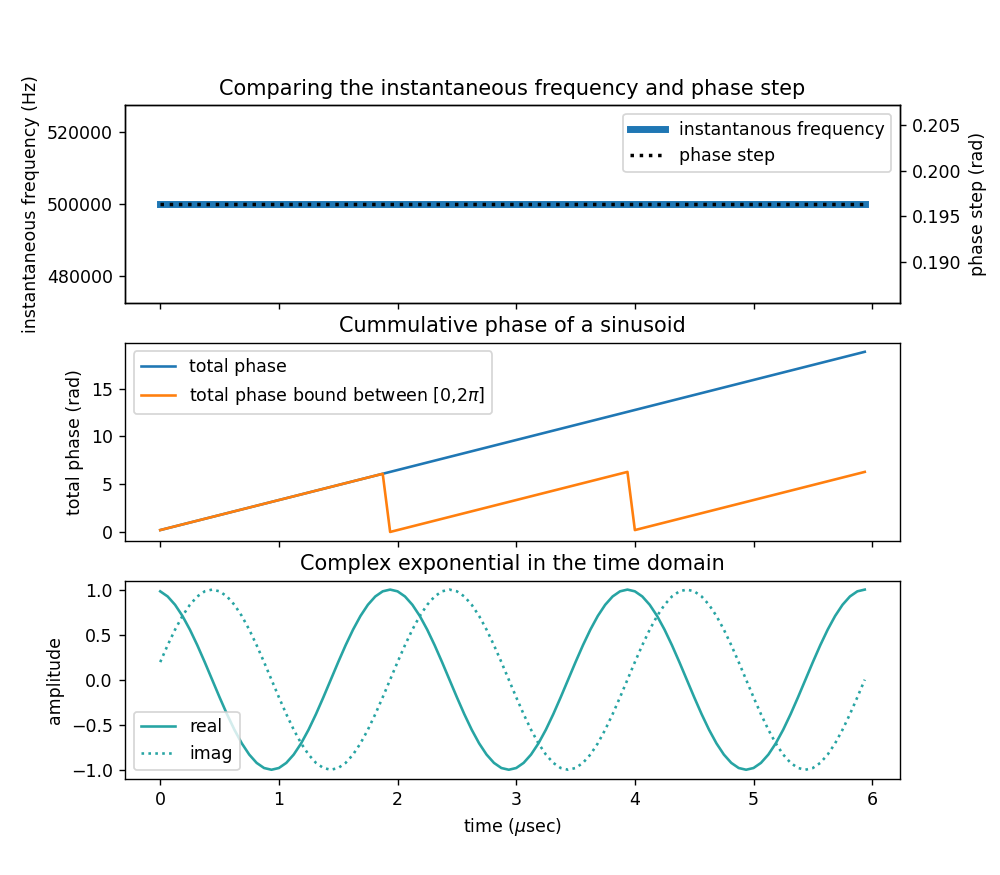

In [17]:
#We now combine everything together and see
fig, ax = plt.subplots(3, 1, sharex=True,figsize = [8, 7])
lns1=ax[0].plot(t_usec,sine_instantaneous_freq_Hz,linewidth=4, label='instantanous frequency');
ax[0].set_title('Comparing the instantaneous frequency and phase step')
ax[0].set_ylabel('instantaneous frequency (Hz)')

axt = ax[0].twinx()
lns2=axt.plot(t_usec,sine_phase_step_rad,linewidth=2,color='black', linestyle=':', label='phase step');
axt.set_ylabel('phase step (rad)')

#ref: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0)

ax[1].plot(t_usec,sine_phase_rad,label='total phase');
ax[1].plot(t_usec,np.fmod(sine_phase_rad,2*np.pi),label='total phase bound between [0,2$\pi$]');
ax[1].set_title('Cummulative phase of a sinusoid')
ax[1].set_ylabel('total phase (rad)')
ax[1].legend()

ax[2].plot(t_usec,np.real(sine),color='#27A4A3',label='real');
ax[2].plot(t_usec,np.imag(sine),color='#27A4A3',label='imag', linestyle=':');
ax[2].set_title('Complex exponential in the time domain')
ax[2].set_xlabel('time ($\mu$sec)')
ax[2].set_ylabel('amplitude')
ax[2].legend();

In [18]:
#We now want to load this into GNURadio. So we will only write the raw file and then load that into GNURadio. This will cause the array size to be lost
sine.astype('complex64').tofile(GNURadioDatafileName)
print(f'The file {GNURadioDatafileName} was generated at the sample rate {int(fs)}. Load this with {GNURadioFlowgraphName}.')

The file ../data/TDS_Introduction_sine_waves_complex64.bin was generated at the sample rate 16000000. Load this with TDS_Introduction_sine_waves.grc.


Start GNURadio companion in the root of the tds-tutorials repo with the command: gnuradio-companion
Then open the file TDS_Introduction_sine_waves.grc and run it. You should see the following output:
<img src="img/TDS_Introduction_sine_waves_output.png" width="566" height="413" />